In [20]:
import pandas as pd

# Path to your Parquet gzip file
file_path_ambu = '../../1_Data/Medical_transport/ambulance_locations.parquet.gzip'
file_path_mug = '../../1_Data/CLEANED/aed_location_latlon.csv'
file_path_pit = '../../1_Data/CLEANED/mug_location_latlon.csv'
file_path_aed = '../../1_Data/CLEANED/mug_location_latlon.csv'
file_path_interventions = '../../1_Data/CLEANED/interventions_dataset.parquet'
file_path_cardiac = '../../1_Data/CLEANED/subset_cardiac.parquet'

# Read the Parquet file into a pandas DataFrame
ambulance_locations = pd.read_parquet(file_path_ambu, engine='pyarrow')
mug_locations = pd.read_csv(file_path_mug, engine='pyarrow')
pit_locations = pd.read_csv(file_path_pit, engine='pyarrow')
aed_locations = pd.read_csv(file_path_aed, engine='pyarrow')
interventions_dataset = pd.read_parquet(file_path_interventions, engine='pyarrow')
subset_cardiac = pd.read_parquet(file_path_cardiac, engine='pyarrow')


In [21]:
mug_locations.rename(columns={'lon': 'longitude', 'lat': 'latitude',}, inplace=True)
pit_locations.rename(columns={'lon': 'longitude', 'lat': 'latitude',}, inplace=True)
aed_locations.rename(columns={'lon': 'longitude', 'lat': 'latitude',}, inplace=True)

In [55]:
import pandas as pd
import plotly.express as px

# Plot map
fig = px.scatter_mapbox(ambulance_locations, lat="latitude", lon="longitude", hover_name="base",
                        color_discrete_sequence=["green"], zoom=10, height=600)
fig.add_scattermapbox(lat=pit_locations['latitude'], lon=pit_locations['longitude'], mode='markers',
                      name='PIT', hoverinfo='text', text=pit_locations['id'],
                      marker=dict(size=5, color='blue'))
fig.add_scattermapbox(lat=mug_locations['latitude'], lon=mug_locations['longitude'], mode='markers',
                      name='MUG', hoverinfo='text', text=mug_locations['id'],
                      marker=dict(size=5, color='red'))
fig.add_scattermapbox(lat=aed_locations['latitude'], lon=aed_locations['longitude'], mode='markers',
                      name='AED', hoverinfo='text', text=aed_locations['id'],
                      marker=dict(size=5, color='orange'))

# Update map layout
fig.update_layout(mapbox_style="open-street-map",
                  title="Locations of Ambulances, PITs, MUGs, and AED Devices",
                  mapbox_zoom=7, mapbox_center={"lat": 50.85, "lon": 4.35})

# Show the map
fig.show()



In [13]:
import folium
from folium.plugins import HeatMap
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import pandas as pd

# Function to calculate haversine distance between two points
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dist = haversine_distances([[lat1, lon1], [lat2, lon2]])[0][1]
    return dist

# Define threshold distance for coloring heatmap
threshold_distance = 0.05  # You can adjust this threshold as needed

# Create a map centered at a specific location (you can adjust the coordinates)
map_center = [50.85045, 4.34878]  # Latitude and longitude of Brussels, Belgium
m = folium.Map(location=map_center, zoom_start=12)

# Filter data for the first week of June 2022
subset_cardiac = subset_cardiac[(subset_cardiac['t0'] >= '2022-06-01') & (subset_cardiac['t0'] < '2022-06-08')]

# Ensure latitude and longitude columns are numeric and drop rows with NaN values
subset_cardiac = subset_cardiac.dropna(subset=['latitude_intervention', 'longitude_intervention', 'longitude_permanence', 'latitude_permanence'])
aed_locations = aed_locations.dropna(subset=['latitude', 'longitude'])
subset_cardiac['latitude_intervention'] = pd.to_numeric(subset_cardiac['latitude_intervention'])
subset_cardiac['longitude_intervention'] = pd.to_numeric(subset_cardiac['longitude_intervention'])
subset_cardiac['latitude_permanence'] = pd.to_numeric(subset_cardiac['latitude_permanence'])
subset_cardiac['longitude_permanence'] = pd.to_numeric(subset_cardiac['longitude_permanence'])
aed_locations['latitude'] = pd.to_numeric(aed_locations['latitude'])
aed_locations['longitude'] = pd.to_numeric(aed_locations['longitude'])

# Iterate over each intervention
for idx_interventions, row_interventions in subset_cardiac.iterrows():
    lat_interventions = row_interventions['latitude_intervention']
    lon_interventions = row_interventions['longitude_intervention']
    lat_permanence = row_interventions['latitude_permanence']
    lon_permanence = row_interventions['longitude_permanence']
    
    # Add marker for intervention
    folium.CircleMarker(
        location=[lat_interventions, lon_interventions],
        radius=3,
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(m)
    
    # Add marker for permanence
    folium.CircleMarker(
        location=[lat_permanence, lon_permanence],
        radius=3,
        color='green',
        fill=True,
        fill_color='green'
    ).add_to(m)
    
    # Draw route between intervention and permanence
    folium.PolyLine(locations=[[lat_interventions, lon_interventions], [lat_permanence, lon_permanence]], color='blue').add_to(m)

# Add markers for AED devices in yellow
for idx_aed, row_aed in aed_locations.iterrows():
    lat_aed = row_aed['latitude']
    lon_aed = row_aed['longitude']
    folium.CircleMarker(
        location=[lat_aed, lon_aed],
        radius=3,
        color='purple',
        fill=True,
        fill_color='purple'
    ).add_to(m)

# Display the map
m




In [19]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Create a map centered at a specific location
map_center = [50.85045, 4.34878]  # Latitude and longitude of Brussels, Belgium
m = folium.Map(location=map_center, zoom_start=12)

# Convert t0 column to datetime format
subset_cardiac['t0'] = pd.to_datetime(subset_cardiac['t0'])

# Group interventions by month
subset_cardiac['month'] = subset_cardiac['t0'].dt.month
interventions_per_month = subset_cardiac.groupby('month').size().reset_index(name='interventions_count')

# Define colors for heatmap
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

# Create heatmap layer for interventions per month
for index, row in interventions_per_month.iterrows():
    month = row['month']
    interventions_count = int(row['interventions_count'])  # Convert int64 to integer
    folium.CircleMarker(
        location=map_center,
        radius=interventions_count * 10,
        color=colors[month - 1],  # Use different colors for each month
        fill=True,
        fill_color=colors[month - 1]
    ).add_to(m)

# Add markers for AED devices in yellow
for idx_aed, row_aed in aed_locations.iterrows():
    lat_aed = row_aed['latitude']
    lon_aed = row_aed['longitude']
    folium.CircleMarker(
        location=[lat_aed, lon_aed],
        radius=3,
        color='yellow',
        fill=True,
        fill_color='yellow'
    ).add_to(m)

# Display the map
m




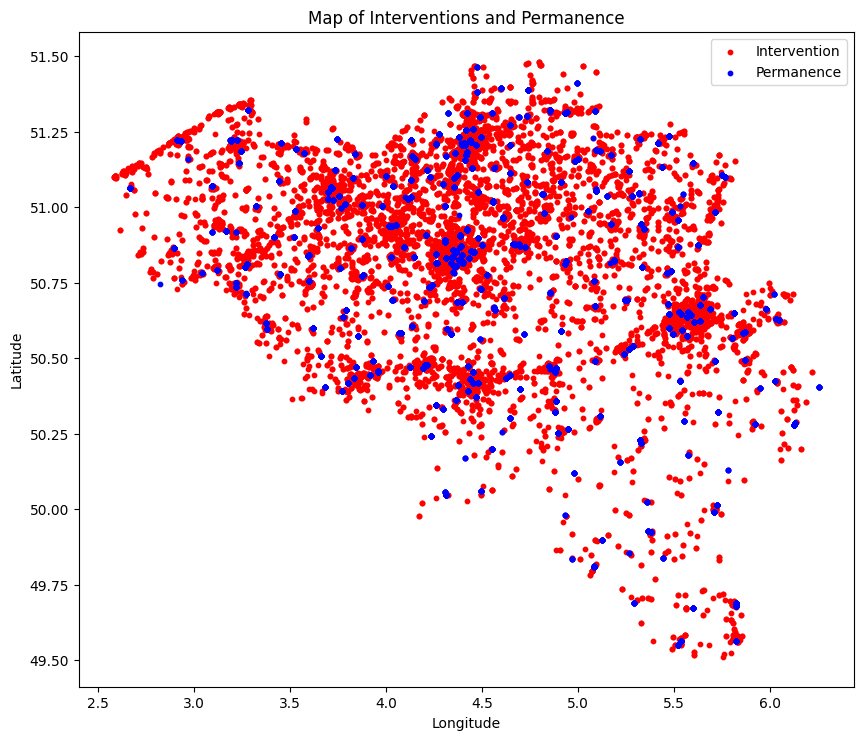

In [22]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Create a DataFrame with latitude and longitude columns
data = subset_cardiac

# Convert latitude and longitude columns to a geometry column
geometry_intervention = [Point(xy) for xy in zip(data['longitude_intervention'], data['latitude_intervention'])]
geometry_permanence = [Point(xy) for xy in zip(data['longitude_permanence'], data['latitude_permanence'])]

# Create GeoDataFrames for intervention and permanence
gdf_intervention = gpd.GeoDataFrame(data, geometry=geometry_intervention, crs='EPSG:4326')
gdf_permanence = gpd.GeoDataFrame(data, geometry=geometry_permanence, crs='EPSG:4326')

# Plot the GeoDataFrames
fig, ax = plt.subplots(figsize=(10, 10))
gdf_intervention.plot(ax=ax, color='red', markersize=10, label='Intervention')
gdf_permanence.plot(ax=ax, color='blue', markersize=10, label='Permanence')
plt.title('Map of Interventions and Permanence')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


NameError: name 'gdf' is not defined

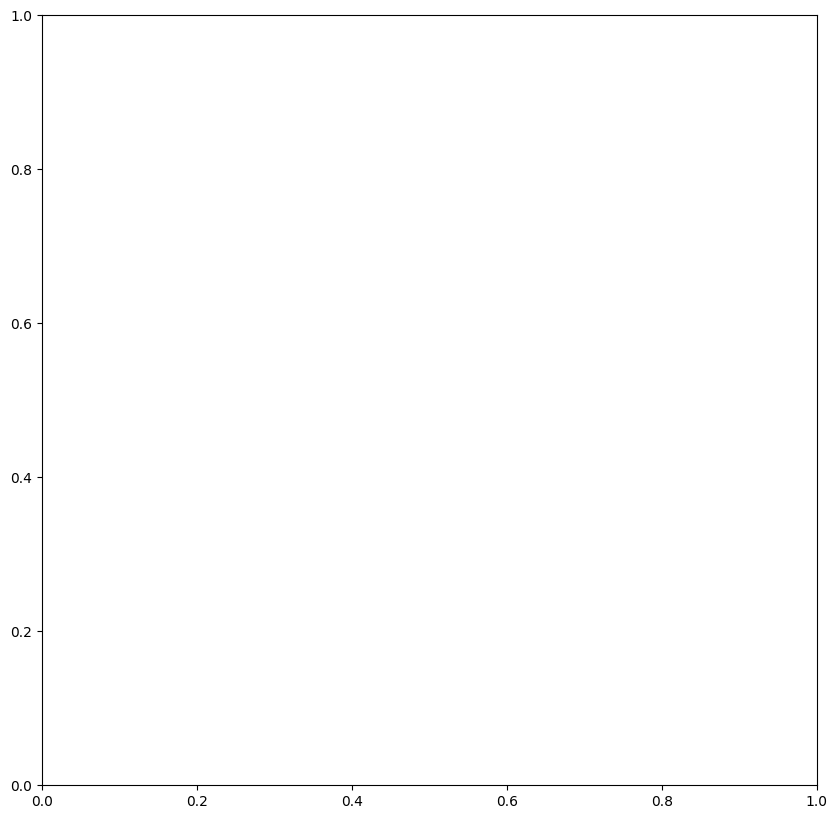

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile or GeoDataFrame for the chloropleth
# Replace 'path_to_shapefile.shp' with the path to your shapefile
# For example: gdf = gpd.read_file('path_to_shapefile.shp')
# gdf = gpd.read_file('path_to_shapefile.shp')

# Let's assume you have a GeoDataFrame named gdf with the geographical boundaries

# Load the subset_cardiac dataset
# Replace 'path_to_subset_cardiac.csv' with the path to your dataset
# For example: subset_cardiac = pd.read_csv('path_to_subset_cardiac.csv')
# subset_cardiac = pd.read_csv('path_to_subset_cardiac.csv')

# Convert latitude and longitude columns to geometry points
# Assuming 'longitude_intervention', 'latitude_intervention', 'longitude_permanence', 'latitude_permanence' are the column names
geometry_intervention = gpd.points_from_xy(subset_cardiac['longitude_intervention'], subset_cardiac['latitude_intervention'])
geometry_permanence = gpd.points_from_xy(subset_cardiac['longitude_permanence'], subset_cardiac['latitude_permanence'])

# Create GeoDataFrames for intervention and permanence points
gdf_intervention = gpd.GeoDataFrame(subset_cardiac, geometry=geometry_intervention)
gdf_permanence = gpd.GeoDataFrame(subset_cardiac, geometry=geometry_permanence)

# Plot the chloropleth map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the chloropleth (replace 'column_name' with the column you want to plot)
gdf.plot(ax=ax, column='column_name', cmap='viridis', legend=True)

# Plot the intervention and permanence points
gdf_intervention.plot(ax=ax, color='red', marker='o', label='Intervention')
gdf_permanence.plot(ax=ax, color='blue', marker='o', label='Permanence')

# Add legend and title
ax.legend()
plt.title('Chloropleth Map with Intervention and Permanence Points')

# Show the plot
plt.show()
